In [1]:
import pandas as pd
from dfply import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,Dense,Flatten,SimpleRNN,LSTM,Dropout
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tensorflow.keras.optimizers import SGD
from sklearn import svm

print(tf.__version__)

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
  

2.1.0
Default GPU Device: /device:GPU:0


In [2]:
df = pd.read_csv("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\behavior-captures\\processed-no-scaling.csv")
df.shape
np.random.shuffle(df.values)

df >>= mutate(drone_present = case_when([df.behavior == 'surround','yes'],
[df.behavior == 'straight','yes'],
[df.behavior == 'noise','no']))
presence_labs = df['drone_present']

In [3]:
x = df.drop(['timestamp','behavior','signal','multiple','drone_present'],axis=1).values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
#time = np.reshape(df['timestamp'].values, (3300, 1))
#x_scaled = np.hstack((x_scaled, time))


In [4]:
values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

y.shape

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
 
model_simple = keras.Sequential(name='Simple_Fully_Connected')
model_simple.add(Dense(128, activation='relu', input_shape=(1280,)))
model_simple.add(Dense(64, activation='relu'))
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dense(2, activation='sigmoid'))


In [5]:
# accy = []
# loss = []
# learn = []
# for i in np.arange(0.001,0.02,0.001):
#     opt = SGD(lr = i)
#     model_large.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     model_large.build(input_shape=(1281,))
#     #model_large.summary()

#     fit_all = model_large.fit(x = x_train,
#             y = y_train, 
#             epochs = 100,
#             batch_size = 64,
#             validation_split = .2,
#             verbose=False)
    
#     scores = model_large.evaluate(x_test,y_test, verbose=0)
#     accy.append(scores[1])
#     loss.append(scores[0])
#     learn.append(i)


In [6]:
# lr = learn[accy.index(max(accy))]
# print(lr)
# print(max(accy))

opt = SGD(lr = .0045)
model_simple.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_simple.build(input_shape=(1280,))
model_simple.summary()

fit_all = model_simple.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 64,
        validation_split = .2,
        verbose=True)

Model: "Simple_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 174,370
Trainable params: 174,370
Non-trainable params: 0
_________________________________________________________________
Train on 2112 samples, validate on 528 samples
Epoch 1/100
2112/2112 [==============================] - 1s 272us/sample - loss: 0.6907 - accuracy: 0.5613 - val_loss: 0.6183 - val_accuracy: 0.7074
Epoch 2/100
2112/2112 [=================

In [7]:
metrics = model_simple.evaluate(x_test,y_test, verbose=0)
print('Test Accuracy: {} %'.format(metrics[1]*100))

Test Accuracy: 87.5 %


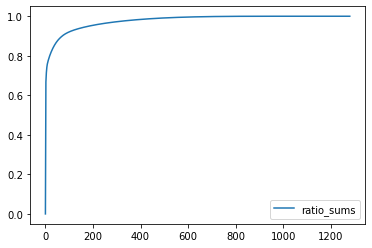

In [8]:
pca = decomposition.PCA(n_components=1280)
pca.fit(x_scaled)
pca_x = pca.transform(x_scaled)

variance = []
for i in range(1280):
    variance.append(sum(pca.explained_variance_ratio_[0:i]))

variance = pd.DataFrame(variance,columns=['ratio_sums'])
plot = variance.plot()


In [9]:
pca = decomposition.PCA(n_components=.95)
pca.fit(x_scaled)
pca_x = pca.transform(x_scaled)
print(pca_x.shape)
x_train, x_test, y_train, y_test = train_test_split(pca_x, y, test_size=0.2)

(3300, 183)


In [10]:
model_pca = keras.Sequential(name='Fully_Connected_w/PCA')
model_pca.add(Dense(128, activation='relu', input_shape=(183,)))
model_pca.add(Dense(64, activation='relu'))
model_pca.add(Dense(32, activation='relu'))
model_pca.add(Dense(2, activation='sigmoid'))

opt = SGD(lr = .0045)
model_pca.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_pca.build(input_shape=(183,))
model_pca.summary()

fit_all = model_pca.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 64,
        validation_split = .2,
        verbose=True)

metrics = model_pca.evaluate(x_test,y_test, verbose=0)
print('Test Accuracy: {} %'.format(metrics[1]*100))


Model: "Fully_Connected_w/PCA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               23552     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 33,954
Trainable params: 33,954
Non-trainable params: 0
_________________________________________________________________
Train on 2112 samples, validate on 528 samples
Epoch 1/100
2112/2112 [==============================] - 0s 178us/sample - loss: 0.7596 - accuracy: 0.4886 - val_loss: 0.6901 - val_accuracy: 0.5398
Epoch 2/100
2112/2112 [====================

In [15]:
print('y train: ' + str(y_train.shape))
print('y test: ' + str(y_test.shape))
print('x train: ' + str(x_train.shape))
print('y test: ' + str(y_test.shape))

x_train = x_train.reshape((1,x_train.shape[0],x_train.shape[1]))
x_test = x_test.reshape((1,x_test.shape[0],x_test.shape[1]))
y_train = y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_test = y_test.reshape((1,y_test.shape[0],y_test.shape[1]))

print('y train: ' + str(y_train.shape))
print('y test: ' + str(y_test.shape))
print('x train: ' + str(x_train.shape))
print('y test: ' + str(y_test.shape))


y train: (2640, 2)
y test: (660, 2)
x train: (2640, 183)
y test: (660, 2)
y train: (1, 2640, 2)
y test: (1, 660, 2)
x train: (1, 2640, 183)
y test: (1, 660, 2)


In [21]:

model_lstm = keras.Sequential(name='LSTM_w/PCA')
model_lstm.add(LSTM(64, return_sequences = True, input_shape = (2640,183)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(64, return_sequences = True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(64, return_sequences = True))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(2, activation='sigmoid'))

opt = SGD(lr = .0045)
model_lstm.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.build()
model_lstm.summary()

fit_all = model_lstm.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 64,
        steps_per_epoch = x_train.shape[1]//64,
        validation_split = .2,
        verbose=True)

metrics = model_lstm.evaluate(x_test,y_test, verbose=0)
print('Test Accuracy: {} %'.format(metrics[1]*100))

Model: "LSTM_w/PCA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 2640, 64)          63488     
_________________________________________________________________
dropout_9 (Dropout)          (None, 2640, 64)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 2640, 64)          33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 2640, 64)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 2640, 64)          33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 2640, 64)          0         
_________________________________________________________________
dense_12 (Dense)             (None, 2640, 2)           1

ValueError: Number of samples 0 is less than samples required for specified batch_size 64 and steps 41

In [19]:
x_train.shape[1]//64

41

In [22]:
from sklearn import neighbors
# n, y = x_train.shape
# x_train_2d = x_train.reshape((n,y))

# n, y = x_test.shape
# x_test_2d = x_test.reshape((n,y))

knn = neighbors.KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)
test = knn.predict(x_test)
knn.score(x_test, y_test)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
from sklearn.svm import SVC
svm = SVC(gamma = 'auto')
svm.fit(x_train, y_train)
test = svm.predict(x_test)
svm.score(x_test, y_test)